
## In this jupyter notebook, <font color='#ff009a'> the seasonal T, ET, REF, NPP are calculated </font> using data from the FAO portal to monitor Water Productivity through Open access of Remotely sensed derived data <font color='#ff009a'> (WaPOR) </font> 
Methodology documents on data used (WaPOR): http://www.fao.org/3/i8225en/I8225EN.pdf#page=17&zoom=100,92,97
**=====================================================================================================================**

![title](img/Fig2_1.png)

**=====================================================================================================================**

## <font color='green'>1 Import modules/libraries</font>

In [1]:
import os                                 # a module for interacting with the operating system
import sys
import glob                               # used to retrieve files/pathnames matching a specified pattern
import re                                 # re sub() module can be used to replace substring

import pandas as pd                       # to store and manipulate tabular data in rows of observations and columns of variables
import geopandas as pdp
import numpy as np                        # stands for 'Numerical Python, is a python library used for scientific computing with arrays
from matplotlib import pyplot as plt      # is a plotting library used for 2D graphics in python 

# change the directory to where the modules are saved
os.chdir(os.path.join(os.path.split(os.getcwd())[0], "Modules"))
from GIS_functions import GIS_function as gis

# <font color='#ff009a'>2 Calculate seasonal T, ET, REF, NPP</font>
#Tranpiration (T), actual evapotranpiration and interception (AETI), reference evapotranpiration (REF) and net primary production (NPP)

## <font color='blue'>a) Import the input data (T, AETI, REF, NPP)</font>

In [2]:
dir_proj = os.path.split(os.getcwd())[0]  
dir_data = "Data"

# transpiration, evapotranpiration & interceptio and reference evapotranspiration
input_folderT = os.path.join(dir_proj, dir_data, "1L2_T_D") 
input_fhsT = glob.glob(input_folderT + '\*.tif')  # glob.glob returns the list of files with their full path

input_folderET = os.path.join(dir_proj, dir_data, "1L2_AETI_D") 
input_fhsET = glob.glob(input_folderET + '\*.tif')   

input_folderRET = os.path.join(dir_proj, dir_data, "1L1_RET_D") 
input_fhsRET = glob.glob(input_folderRET + '\*.tif')

input_folderNPP = os.path.join(dir_proj, dir_data, "1L2_NPP_D") 
input_fhsNPP = glob.glob(input_folderNPP + '\*.tif')

# Masks: landcover layers and the shape of the project area
input_LCCfolder = os.path.join(dir_proj, dir_data, "1L2_LCC_A") 
LCC_tifs        = glob.glob(input_LCCfolder + '\*.tif')

ProArea = gis.OpenAsArray(r'..\Data\1Boundary\mask_irrigation_types.tif', nan_values=True)  # he project area (tif)

## <font color='blue'>b) Identify the time of the raster (cube code)</font>

![title](img/Fig2_2.jpg)

<span style='background :lightgreen'>================================================================================
* <span style='background :pink' > Running the following cell activate the 'WaPOR' module that requires internet connection and takes longtime to download the the catalog 
* <span style='background :lightgreen' > **Run the cell only one time, if the latest date in the 'time_range' is updated.**
* <span style='background :pink' > While running this section for the first time, the the catalog info is saved in the working directory.
* <span style='background :pink' > Running the notebook for the second time should skip this cell, but run the next one (# read the df_avial from already saved excel under the Data) 
    
<span style='background :lightgreen'>================================================================================

In [3]:
import WaPOR                                # API to interact with WaPOR portal
WaPOR.API.version = 2

# read the cube info (dataframe) from the cataloge 
cube_codeT   = 'L2_T_D' 
cube_codeET  = 'L2_AETI_D' 
cube_codeRET = 'L1_RET_D' 
cube_codeNPP = 'L2_NPP_D' 

time_range   = '2009-01-01,2019-12-31'

df_availT    = WaPOR.API.getAvailData(cube_codeT,   time_range)
df_availET   = WaPOR.API.getAvailData(cube_codeET,  time_range)
df_availRET  = WaPOR.API.getAvailData(cube_codeRET, time_range)
df_availNPP  = WaPOR.API.getAvailData(cube_codeNPP, time_range)

# save the dataframe to excel to access it offline
output_folder = os.path.join(os.path.split(os.getcwd())[0], "Data") 

df_availT.to_excel(os.path.join(output_folder,   'df_availT.xlsx'))
df_availET.to_excel(os.path.join(output_folder,  'df_availET.xlsx'))
df_availRET.to_excel(os.path.join(output_folder, 'df_availRET.xlsx'))
df_availNPP.to_excel(os.path.join(output_folder, 'df_availNPP.xlsx'))

# Get personaL WAPOR API Token by registering in the top right cornor of the page: wapor.apps.fao.org/home/1

Insert WAPOR API Token: 89bb4904914c62f2878ab36b35884ca391eb3c2c1795dba38537dff2e012b3a091b56fdea7236f44
Loading WaPOR catalog...


In [3]:
# read the df_avial from already saved excel 

time_range  = '2009-01-01,2019-12-31'

df_availT   = pd.read_excel('../data/df_availT.xlsx')
df_availET  = pd.read_excel('../data/df_availET.xlsx')
df_availRET = pd.read_excel('../data/df_availRET.xlsx')
df_availNPP = pd.read_excel('../data/df_availNPP.xlsx')

## <font color='blue'>c) Make or connect with the directory the output folder</font>

In [4]:
# the directory of the output folder
dir_proj = os.path.split(os.getcwd())[0]  
dir_data = "Data"
output_folderT   = os.path.join(dir_proj, dir_data, "2L2_T_season") 
output_folderET  = os.path.join(dir_proj, dir_data, "2L2_AETI_season") 
output_folderRET = os.path.join(dir_proj, dir_data, "2L1_RET_season") 
output_folderNPP = os.path.join(dir_proj, dir_data, "2L2_NPP_season") 

# Make one if the folder does not exit
if not os.path.exists(output_folderT):
    os.makedirs(output_folderT) 
if not os.path.exists(output_folderET):
    os.makedirs(output_folderET) 
if not os.path.exists(output_folderRET):
    os.makedirs(output_folderRET) 
if not os.path.exists(output_folderNPP):
    os.makedirs(output_folderNPP) 

## <font color='blue'>d) Define function to add the rasters from start to end of seasons</font>
* <font color='#ff009a'>This function calculate the seasonal value given rasters at dekadal time interval</font>
* <font color='#ff009a'>update the appopriate land class and boundary:</font> Sums = np.where((Lcc='cropped land') & (ProArea='project boundary')

In [5]:
# summation of raster between two dates
def SumSeason(input_fhs, saveSum, sowing_date, harvesting_date, ProArea, df_avail, LCC):
    """
    Add raster files (input_fhs) between sowing_date and harvesting_date.

    IHE Delft 2019
    Authors: a.chukalla@un-ihe.org
    @author: Abebe Chukalla

    Parameters
    ----------
    input_fhs : raster file
        Files to be added.
    saveSum : folder name
        Folder name where the sum to be saved.
    sowing_date : date in yyyy-mm-dd format
        Starting date of crop growth.
    harvesting_date : date in yyyy-mm-dd format
        Harvesting date of crop.
    ProArea : tiff file
        Folder holding the boundary of the crop land.
    df_avail : cube_code of the raster
        Helps to read the date of each raster file.
    LCC : Land cover tiff files
        Helps to select irrigated/rainfed land classes.
        
    Returns
    -------
    Sums: array
        Seasonal, sum of the raster files.
    """
    period_dates = pd.date_range(sowing_date, harvesting_date, freq='D')  # generate dates b/n sowing and harvesting dates
    period_fhs   = []

    # collect the rasters if they are within sowing and harvesting date
    for in_fh in input_fhs:
        # get raster id from file name
        raster_id = os.path.split(in_fh)[-1].split('.')[0]               
        # get raster info using raster id
        raster_info = df_avail.loc[df_avail['raster_id']==raster_id]      # the time_code corresponding to raster id
        # get start and end date of raster
        raster_startdate = raster_info['time_code'].iloc[0].split(',')[0] 
        raster_startdate = re.sub(r"[[)]", "", raster_startdate)          
        raster_enddate = raster_info['time_code'].iloc[0].split(',')[-1]  
        raster_enddate = re.sub(r"[[)]", "", raster_enddate)               
        # check if raster belong to period
        if ((raster_startdate in period_dates) or (raster_enddate in period_dates)):
            period_fhs.append(in_fh)

    # add the layers between the sowing and harvesting dates
    period_fhs
    period_fh = period_fhs[0]
    Sums = 0
    for period_fh in period_fhs:
        Sum = gis.OpenAsArray(period_fh, nan_values=True)
        Sums += Sum
       
    # maskout non cropped and areas outside the project boundary 
    Lcc = gis.OpenAsArray(LCC, nan_values=True)
    Sums = np.where((Lcc==42) & (ProArea<=3), Sums, np.nan)
    
    # save the array in raster format, name it with the raster_id and sowing and harvesting date
    out_fh = os.path.join(saveSum, raster_id.split('_')[1] + '_' + str(sowing_date) + '_to_' + str(harvesting_date) + '.tif')        
    gis.CreateGeoTiff(out_fh, Sums, driver, NDV, xsize, ysize, GeoT, Projection)  # Save the array 'Sums' as raster
        
    return Sums  

## <font color='blue'>e) Define the Start Of crop Season (SOS) and End Of crop Season (EOS)</font>
* Edit the start and end of crop seasons <font color='#ff009a'>in the df_SOsEos.xlsx file in the data folder</font>
* The start and end of crop seasons are identical for a season and raster file

In [6]:
df_dates = pd.read_excel('../data/df_SosEos.xlsx')
df_dates

,Seasons,SOS,EOS
0,1,2009-10-01,2010-09-30
1,2,2010-10-01,2011-09-30
2,3,2011-10-01,2012-09-30
3,4,2012-10-01,2013-09-30
4,5,2013-10-01,2014-09-30
5,6,2014-10-01,2015-09-30
6,7,2015-10-01,2016-09-30
7,8,2016-10-01,2017-09-30
8,9,2017-10-01,2018-09-30
9,10,2018-10-01,2019-09-30


### <font color='#ff009a'>2.i) Calculate seasonal transpiration (T)

C:\Users\ach006\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: FutureWarning: Possible nested set at position 1
C:\Users\ach006\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in less_equal


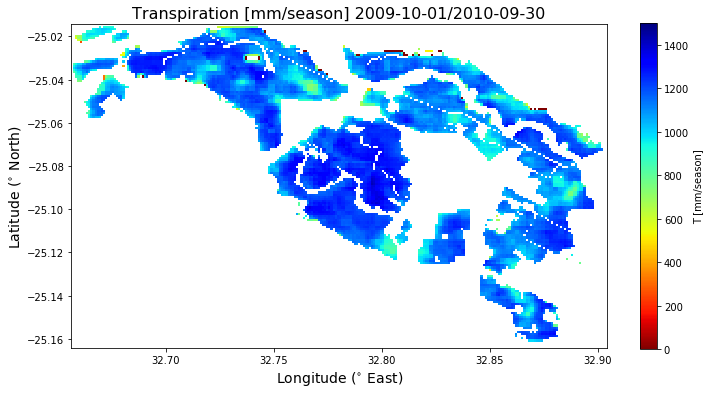

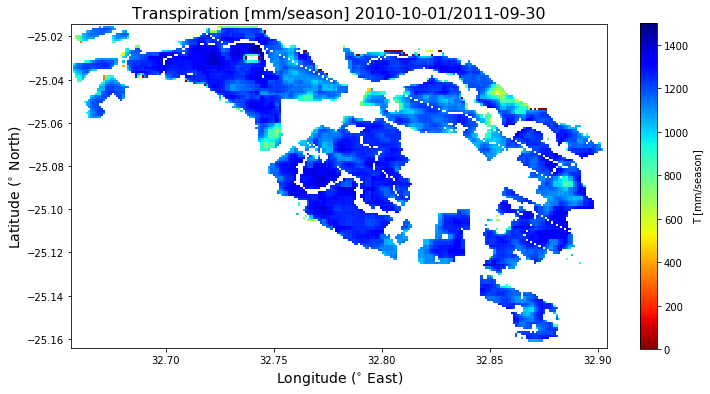

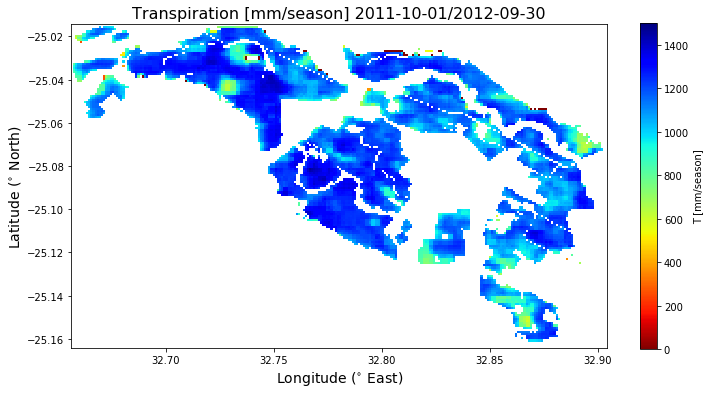

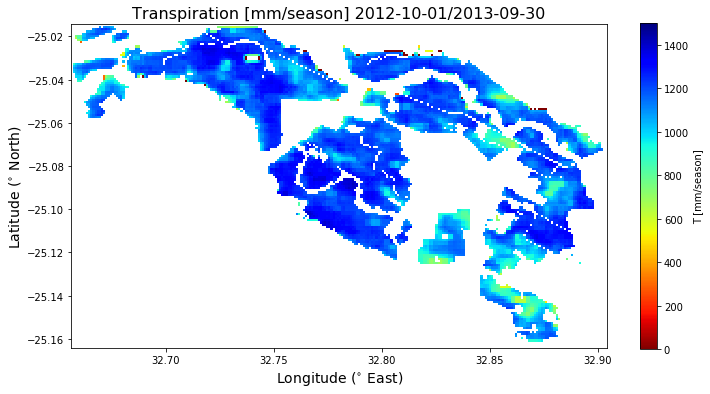

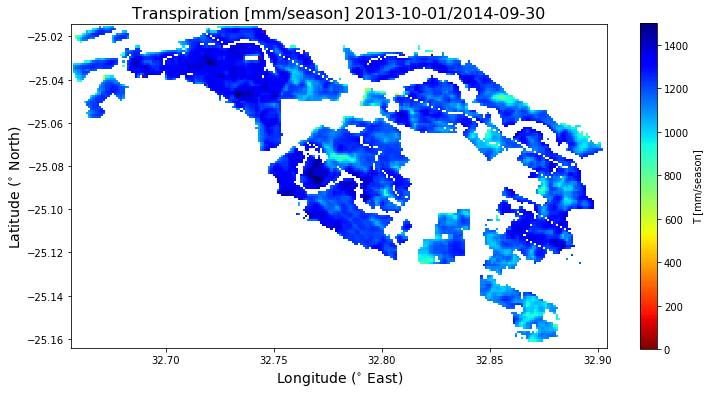

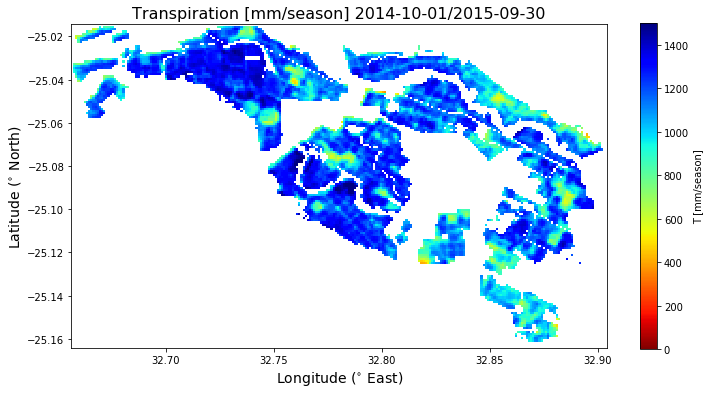

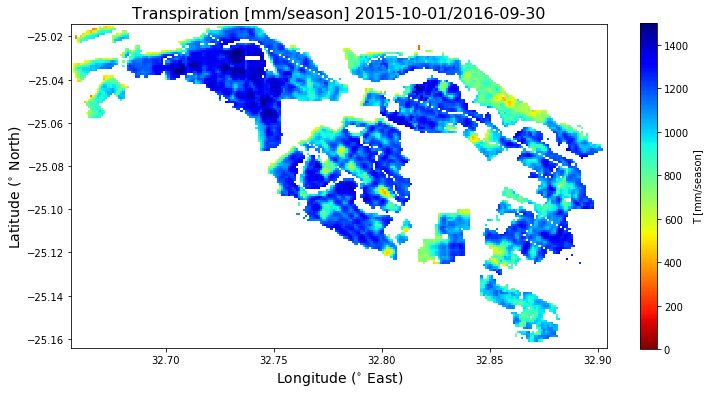

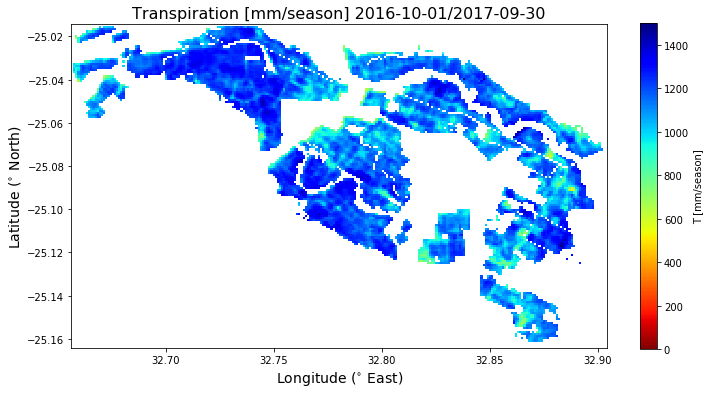

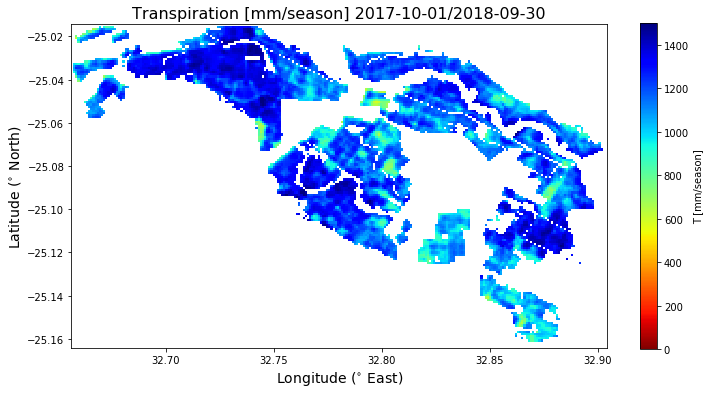

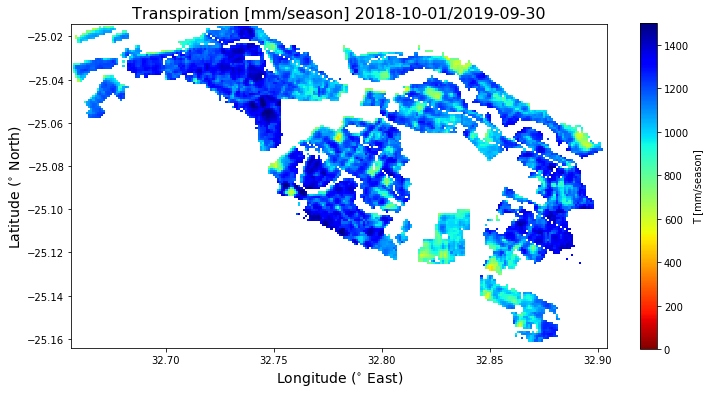

In [7]:
# collecting Geoinfo such as projection, the x and y axis
in_fh = input_fhsT[0]  

driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

length = len(df_dates)  # length of season

i = 0
while i < length:
    # calculate the seasonal value and save in output_folderT
    seasonal = SumSeason(input_fhsT, output_folderT, df_dates.SOS[i].date(), df_dates.EOS[i].date(), ProArea, df_availT, LCC=LCC_tifs[i])

    # Plot the raster map
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal, cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='T [mm/season]')
    plt.xlabel('Longitude ($^{\circ}$ East)', fontsize=14)  # add axes label
    plt.ylabel('Latitude ($^{\circ}$ North)', fontsize=14)
    plt.title('Transpiration [mm/season] ' + str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), fontsize=16)
    plt.clim(0,1500)
    plt.show ()
    
    i += 1

### <font color='#ff009a'>2.ii) Calculate seasonal evapotratranspiration

C:\Users\ach006\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in less_equal


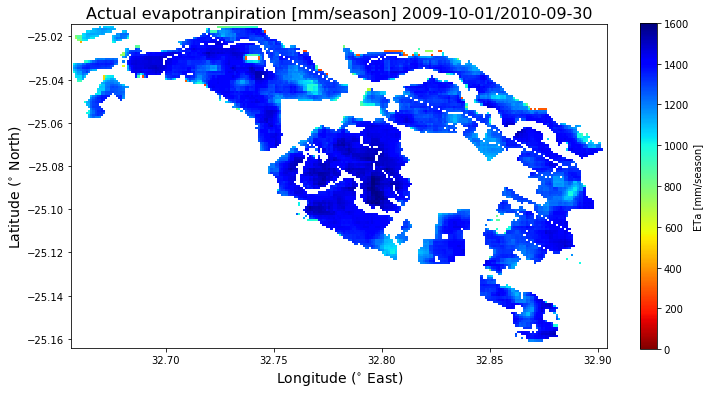

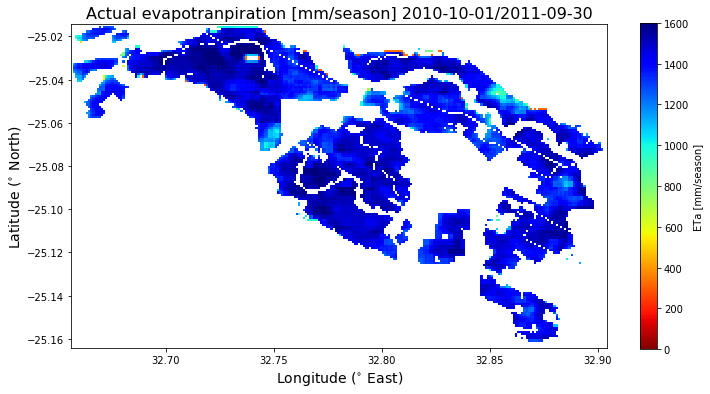

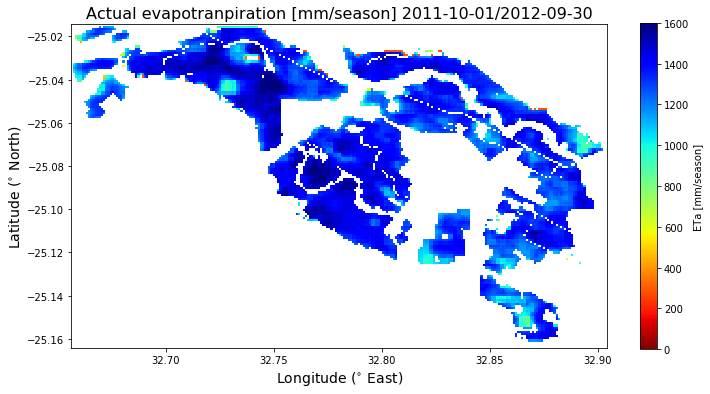

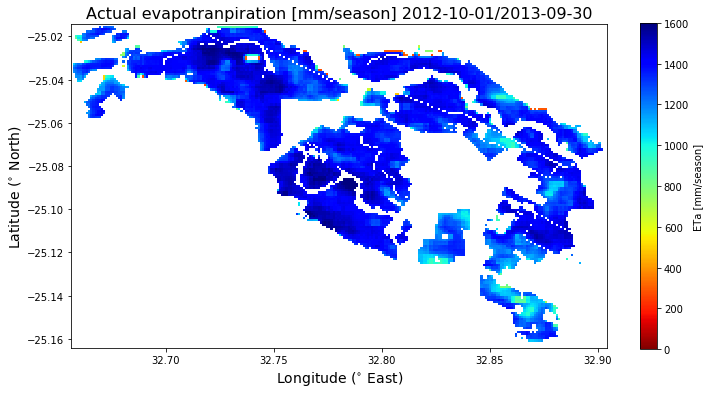

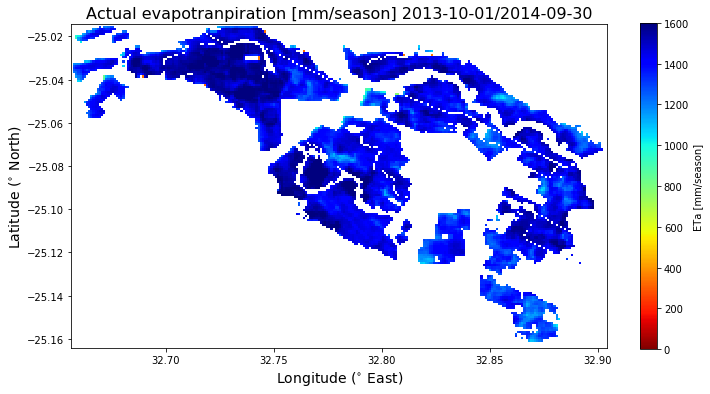

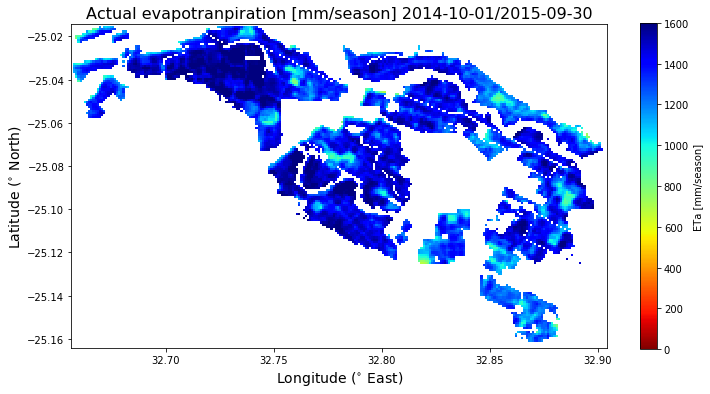

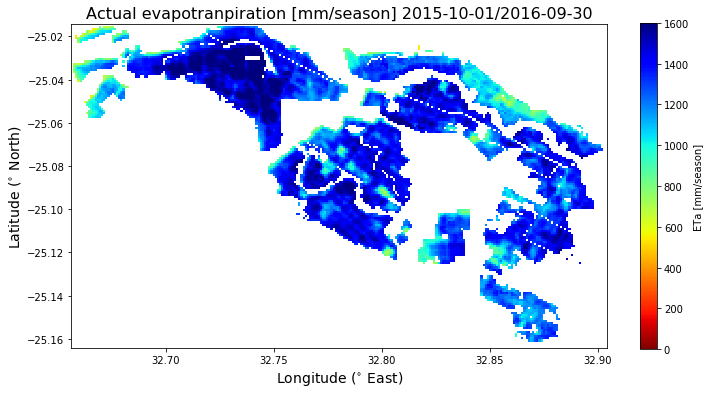

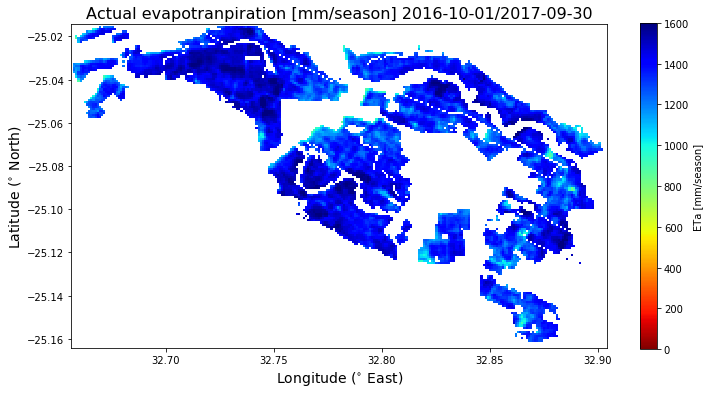

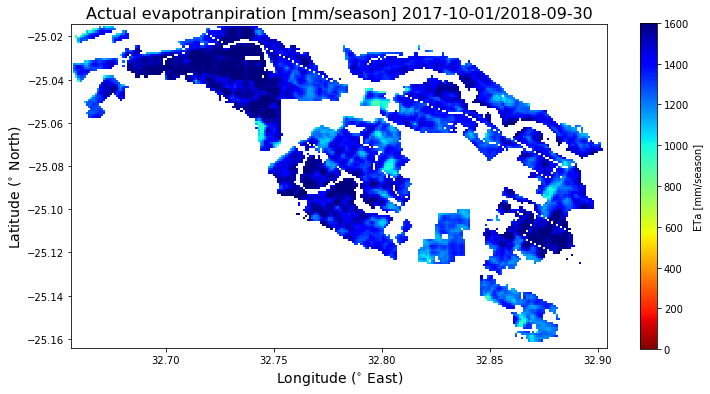

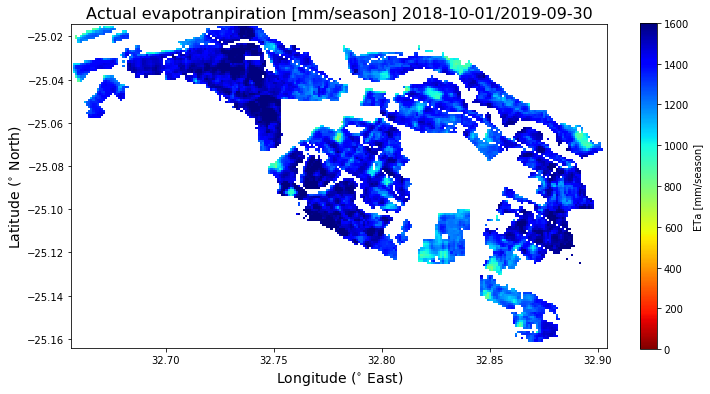

In [8]:
# collecting Geoinfo such as projection, the x and y axis
in_fh = input_fhsET[0]    

driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

length = len(df_dates)  # length of seasonn
                
i = 0
while i < length:
    # calculate the seasonal value and save in output_folder
    seasonal = SumSeason(input_fhsET, output_folderET, df_dates.SOS[i].date(), df_dates.EOS[i].date(), ProArea, df_availET, LCC=LCC_tifs[i])

    # Plot the raster map
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal, cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='ETa [mm/season]')
    plt.xlabel('Longitude ($^{\circ}$ East)', fontsize=14)  # add axes label
    plt.ylabel('Latitude ($^{\circ}$ North)', fontsize=14)
    plt.title('Actual evapotranpiration [mm/season] ' + str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), fontsize=16)
    plt.clim(0,1600)
    plt.show()

    i += 1

### <font color='#ff009a'>2.iii) Calculate seasonal Reference Evapotranpiration(RET)

C:\Users\ach006\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in less_equal


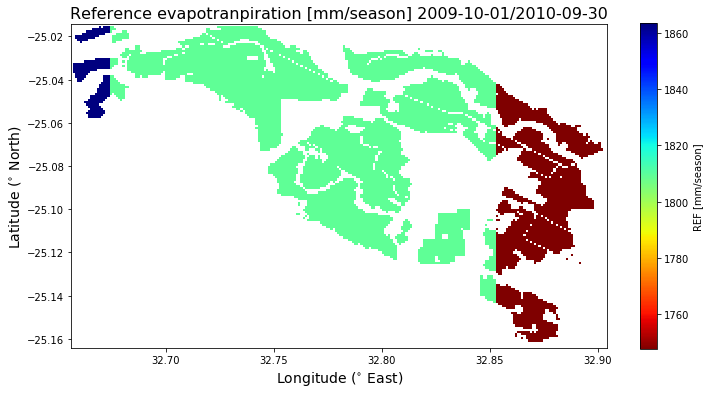

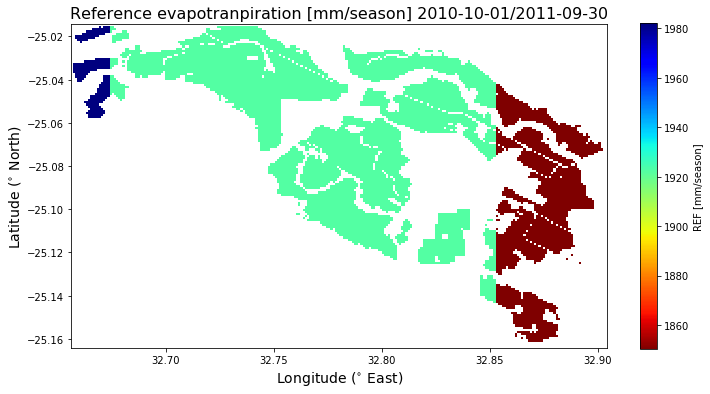

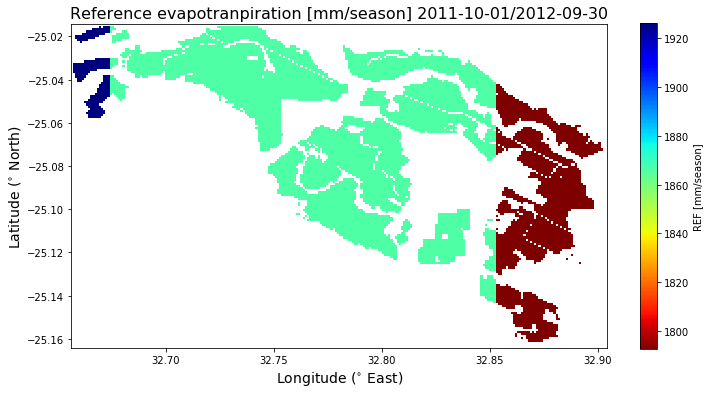

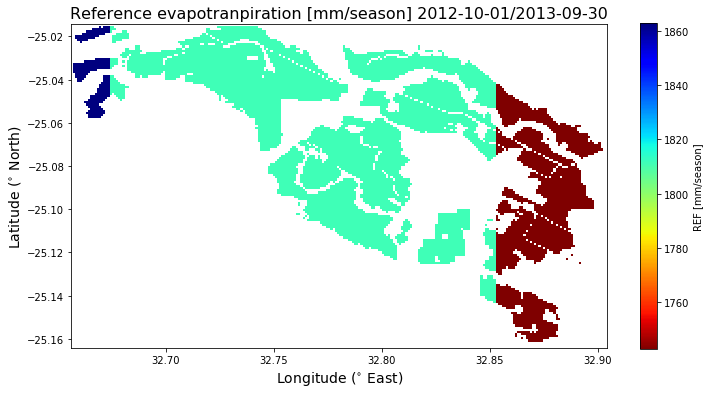

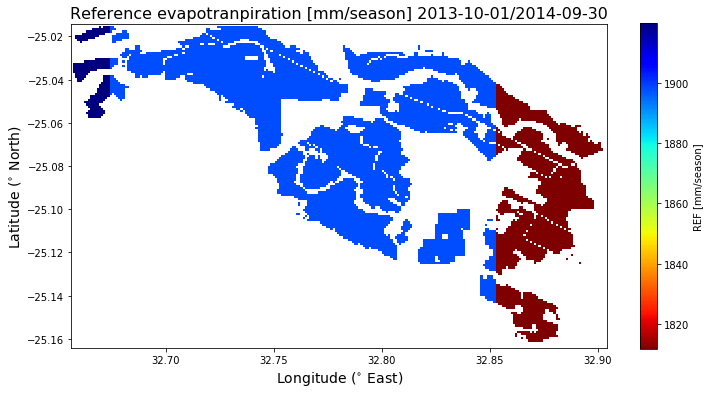

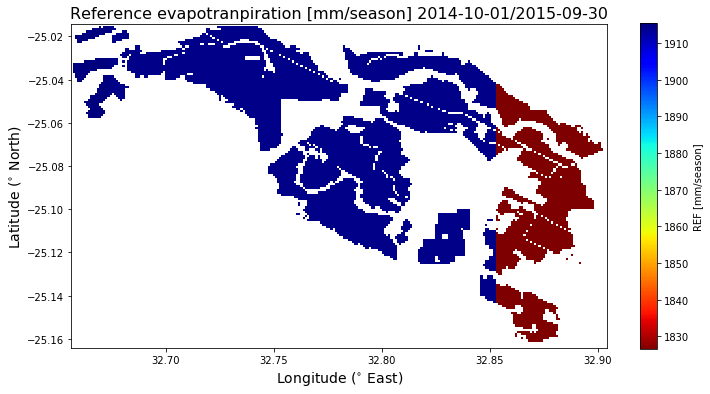

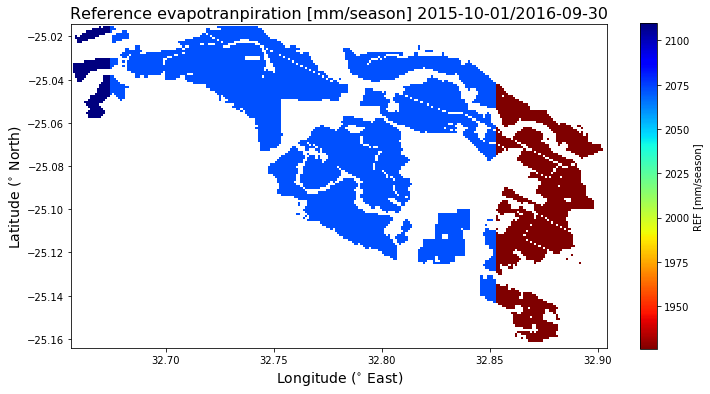

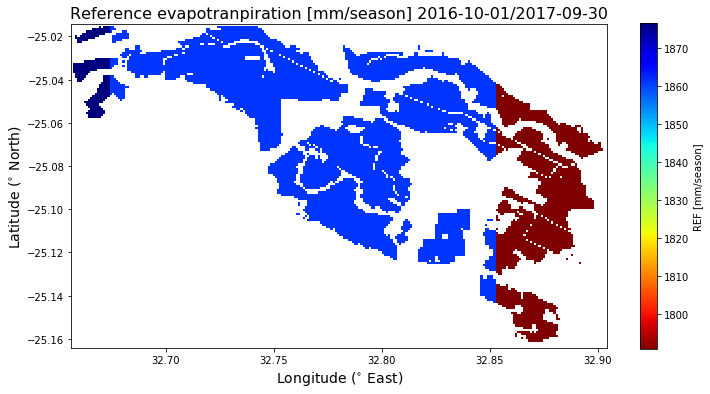

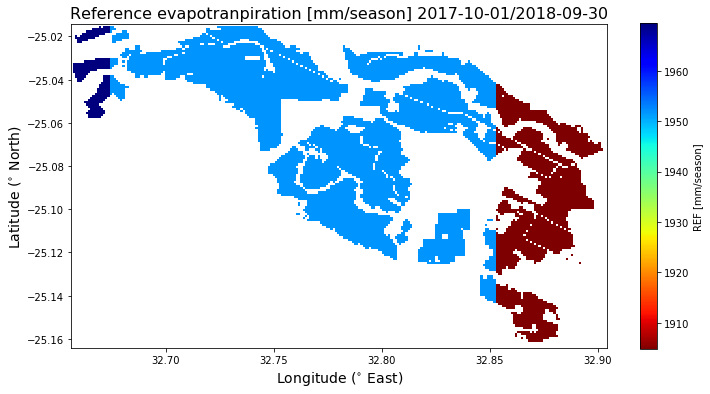

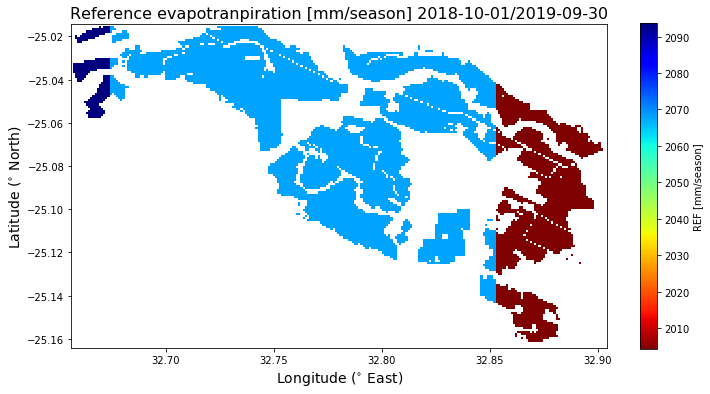

In [9]:
# collecting Geoinfo such as projection, the x and y axis
in_fh = input_fhsRET[0]
driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

length = len(df_dates)  # length of season

i = 0
while i < length:
    # 
    seasonal = SumSeason(input_fhsRET, output_folderRET, df_dates.SOS[i].date(), df_dates.EOS[i].date(), ProArea, df_availRET, LCC=LCC_tifs[i])

    # Plot the raster map
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal, cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='REF [mm/season]')
    plt.xlabel('Longitude ($^{\circ}$ East)', fontsize=14)  # add axes label
    plt.ylabel('Latitude ($^{\circ}$ North)', fontsize=14)
    plt.title('Reference evapotranpiration [mm/season] ' + str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), fontsize=16)
    plt.show ()

    i += 1

### <font color='#ff009a'>2.iv) Calculate seasonal Net Primary Production (NPP)

C:\Users\ach006\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in less_equal


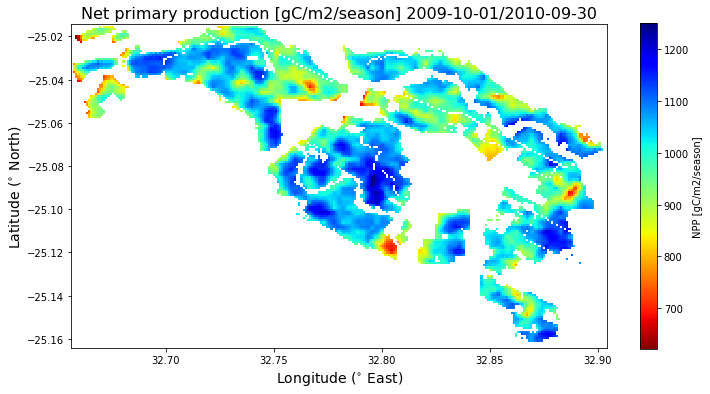

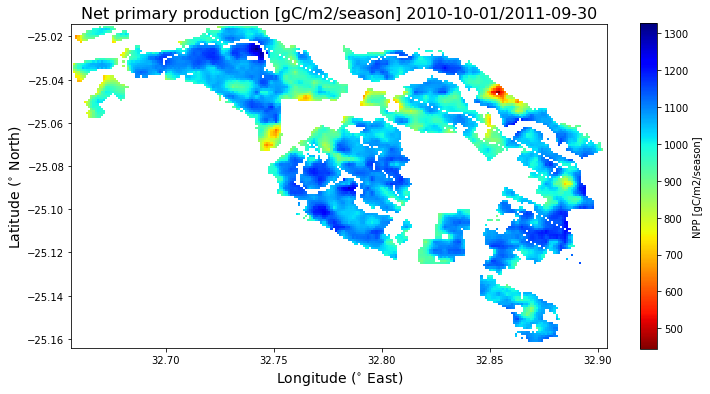

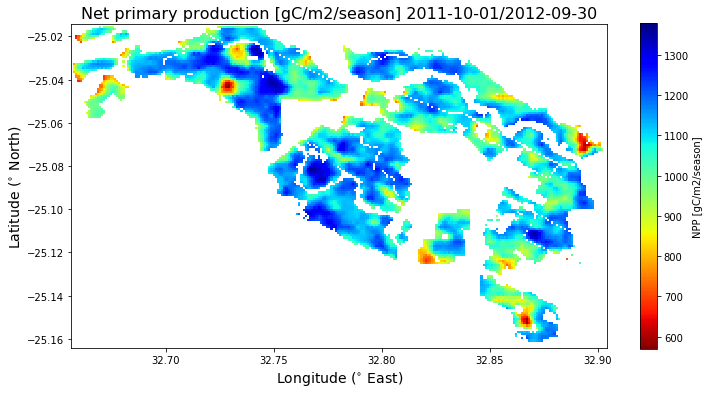

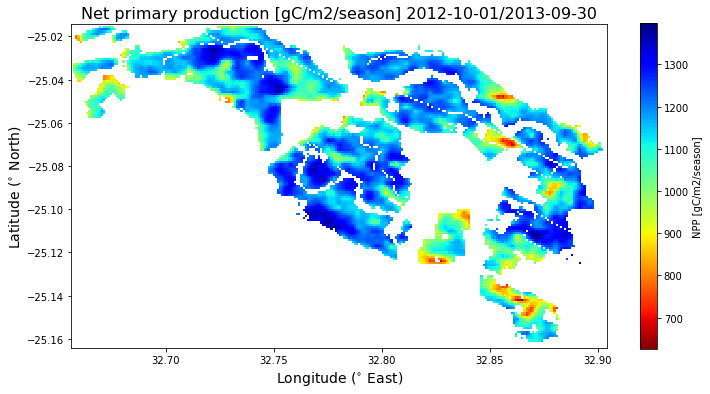

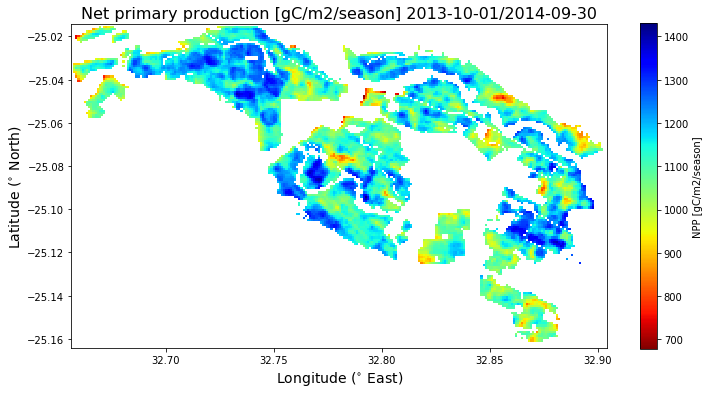

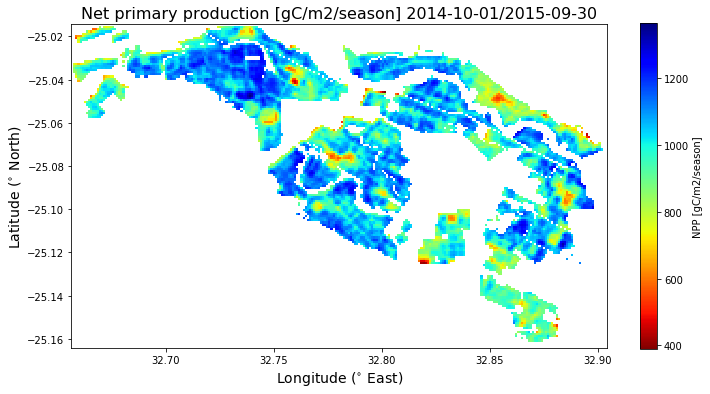

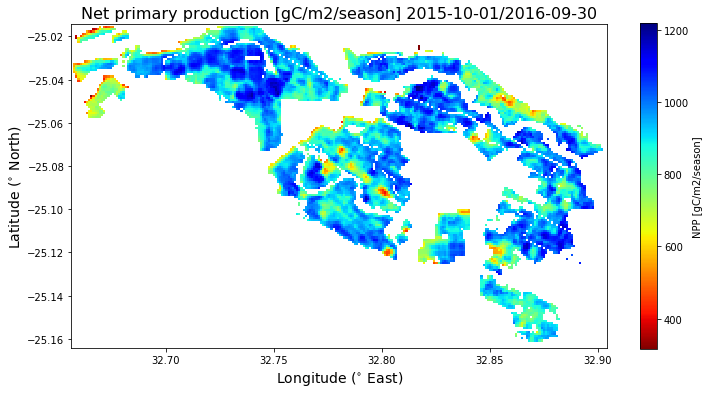

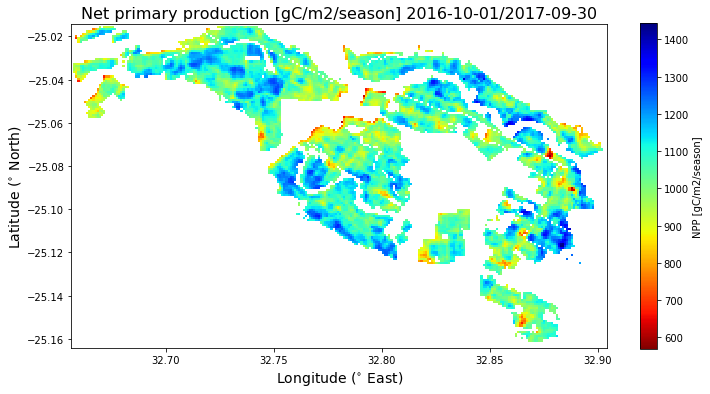

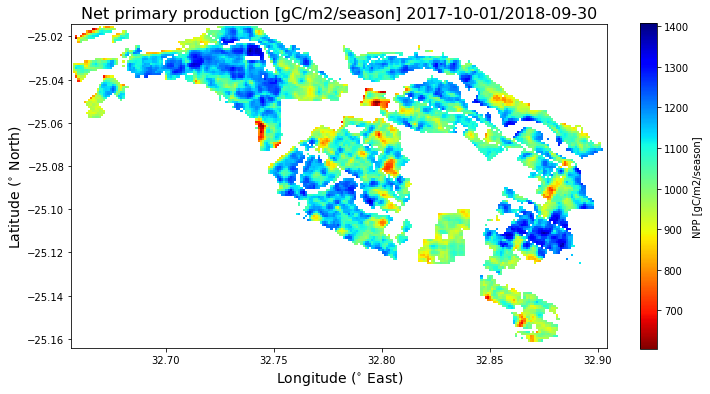

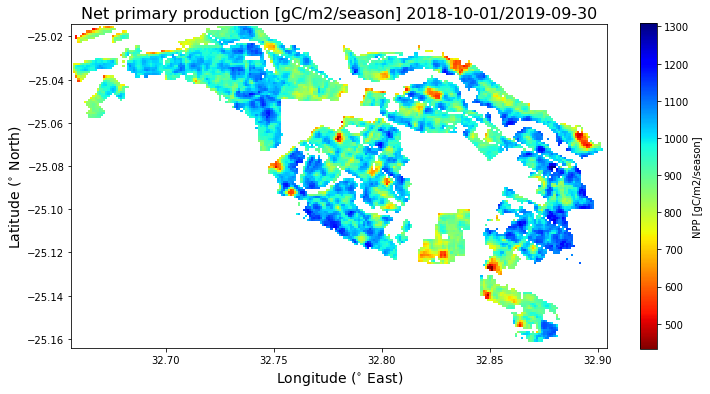

In [10]:
# collecting Geoinfo such as projection, the x and y axis
in_fh = input_fhsNPP[0]

driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

length = len(df_dates)  # length of season

i = 0
while i < length:
    # 
    seasonal = SumSeason(input_fhsNPP, output_folderNPP, df_dates.SOS[i].date(), df_dates.EOS[i].date(), ProArea, df_availNPP, LCC=LCC_tifs[i])

    # Plot the raster map
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal, cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='NPP [gC/m2/season]')
    plt.xlabel('Longitude ($^{\circ}$ East)', fontsize=14)  # add axes label
    plt.ylabel('Latitude ($^{\circ}$ North)', fontsize=14)
    plt.title('Net primary production [gC/m2/season] ' + str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), fontsize=16)
    plt.show ()
    
    i += 1  


# Exercise 
## Calculate seasonal T, ET, RET and NPP for your project area 